# Toy problem : combining a neural network with equations

Author: Charles Le Losq, Australian National University, 2019.

In this problem, we want a neural network to predict the parameter of a function that allows calculation of the $y$ observations.

We will use Torch in Python to approach this problem in this notebook.

See also the version using Julia + Flux.jl for a side to side comparison.

In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time
from torch.utils import data

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42) # fixing random seed

# The problem

$y$ depends on $x1$ and $x2$ via the equation

$y = B \times cos(\frac{(x2-A)}{C})$   eq. 1

with $C$ a constant and $A, B = f(x1)$, with $f$ unknown. Here we will generate a toy dataset with a simple $f$ and $x1$ with 1 feature, but in reality $f$ is a stronly non-linear function and inputs $x1$ have multiple features.

In [2]:
def model(x2,A,B,C): # this is eq. 1
    return B*np.cos((x2-A)/C)

# here we assume we know how A, B and C vary with x1
def fake_eq0(x1):
    A = 100.0*x1 # constant
    B = 4.0*x1
    C = 10.0
    return A, B, C

x1 = np.around(np.arange(0.4,1.0,0.01,dtype='Float64'),2)
x2 = np.arange(500.0,1000.0,1.0)

A_fake, B_fake, C_fake = fake_eq0(x1)

# we buyild our training set
for i in range(0,len(B_fake)):
    if i == 0:
        X1_training = np.ones(len(x2))*x1[i]
        X2_training = x2
        y_training = model(x2,A_fake[i],B_fake[i],C_fake)
    else:
        X1_training = np.hstack((X1_training,np.ones(len(x2))*x1[i]))
        X2_training = np.hstack((X2_training,x2))
        y_training = np.hstack((y_training,model(x2,A_fake[i],B_fake[i],C_fake)))

# ensuring that the shape of the arrays are good        
X1_training = X1_training.reshape(-1,1)
X2_training = X2_training.reshape(-1,1)
y_training = y_training.reshape(-1,1)

/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # This is added back by InteractiveShellApp.init_path()


# Train-valid split

Something we may want to take care of now is to split our dataset in train-valid splits.

I use the sklearn function train_test_split to do it below easily, then save everything in two dictionaries.

In [3]:
X1_train, X1_valid, X2_train, X2_valid, y_train, y_valid = train_test_split(X1_training, X2_training, y_training,train_size = 0.7, random_state=42)

datas_train = {"X1" : X1_train,
        "X2" : X2_train,
        "y" : y_train}

datas_valid = {"X1" : X1_valid,
        "X2" : X2_valid,
        "y" : y_valid}

/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Let's do a nice plot to see our data

Dataset train size is (21000, 1)
Dataset valid size is (9000, 1)


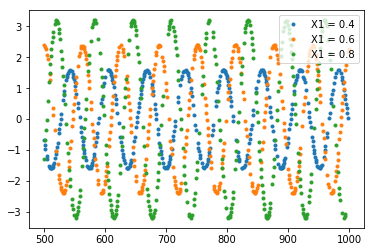

In [4]:
for i in [0.4,0.6,0.8]:
    plt.plot(datas_train["X2"][datas_train["X1"]==i],
             datas_train["y"][datas_train["X1"]==i],
             ".",label="X1 = {}".format(i))

plt.legend()

print("Dataset train size is", datas_train["X1"].shape)
print("Dataset valid size is", datas_valid["X1"].shape)

# Solving the problem: 

Combine neural net to predict B and C, we also know that A and D are constant so we solve them at the same time, and then use this in eq .1 to predict our observations.

We write a custom NN below in Pytorch to do the job, using DataSet loader to load data, splitting the data in train-valid. If a GPU supporting CUDA is detected, we use GPU for training but CPU in parallel for data loading.


In [5]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Running on {}".format(device))

Running on cpu


Now we set parameters for training

In [6]:
# Parameters
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 4}

We build a DataLoader Pytorch object to perform mini-batch learning...

This also send the data on device (CPU or GPU)

In [7]:
# dataset in Pytorch format
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, datas,device):
        '''Initialization
        
        Input
        -----
        Datas : dict with keys X1, X2 and y corresponding to those data
        '''
        self.X1 = torch.FloatTensor(datas["X1"]).to(device)
        self.X2 = torch.FloatTensor(datas["X2"]).to(device)
        self.y = torch.FloatTensor(datas["y"]).to(device)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X1 = self.X1[index]
        X2 = self.X2[index]
        y = self.y[index]

        return X1, X2, y

Let's load data and see if it works!

In [8]:
DS_train = Dataset(datas_train,device)
DS_valid = Dataset(datas_valid,device)
# we grab the first element
print(DS_train.__getitem__(0))
print(DS_valid.__getitem__(0))

(tensor([0.9600]), tensor([965.]), tensor([1.8619]))
(tensor([0.4400]), tensor([808.]), tensor([0.9483]))


We then use the torch dataloader to iterate through the dataset

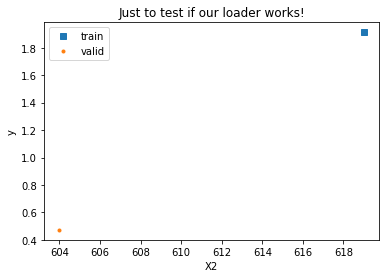

In [9]:
loader_train = data.DataLoader(DS_train, **params)
loader_valid = data.DataLoader(DS_valid, **params)

# get some images
dataiter_train = iter(loader_train)
values_train = dataiter_train.next()

dataiter_valid = iter(loader_valid)
values_valid = dataiter_valid.next()

# Plot things to see it worling
plt.plot(values_train[1].detach().numpy()[values_train[0].detach().numpy()==0.6],
         values_train[2].detach().numpy()[values_train[0].detach().numpy()==0.6],"s",label="train")
plt.plot(values_valid[1].detach().numpy()[values_train[0].detach().numpy()==0.6],
         values_valid[2].detach().numpy()[values_train[0].detach().numpy()==0.6],".",label="valid")
plt.title("Just to test if our loader works!")
plt.xlabel("X2")
plt.ylabel("y")
plt.legend()

Now we define the custom neural network object: 

- a neural network predicts B and C;
- A and D a just global parameters that will be adjusted too 
- we use the eq. 1 to predict y. 

Pytorch allows use to follow the gradient all the way!

In [10]:
class Feedforward(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,p_drop=0.3):
        super(Feedforward, self).__init__()
        
        # init parameters
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.num_layers  = num_layers
        
        # network related torch stuffs
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=p_drop)

        self.linears = torch.nn.ModuleList([torch.nn.Linear(input_size, self.hidden_size)])
        self.linears.extend([torch.nn.Linear(self.hidden_size, self.hidden_size) for i in range(1, self.num_layers)])
      
        # output = B and C 
        self.out = torch.nn.Linear(self.hidden_size, 2) # Linear output
        
        # now declaring constant C as a variable
        # we want to provide a plausible starting value for this parameter
        self.C = torch.nn.Parameter(data=torch.tensor([np.log(9.5)]))
    
    def eq1(self,x2): # this is eq. 1
        return self.B*torch.cos((x2-self.A)/torch.exp(self.C))
    
    # This part is very important. As we do not scale the data, we need to set output bias close to the expected
    # values of the parameters B and C
    def output_bias_init(self):
        self.out.bias = torch.nn.Parameter(data=torch.tensor([np.log(50.),np.log(3.)]))
    
    def forward(self, x1, x2):
        """core neural network"""
        for layer in self.linears: # Feedforward
            x1 = self.dropout(self.relu(layer(x1)))
        output = self.out(x1)
        
        # extract parameters from network
        self.A = torch.exp(output[:,0])
        self.B = torch.exp(output[:,1])
        
        # need to reshape things
        self.A = torch.reshape(self.A, (self.A.shape[0], 1))
        self.B = torch.reshape(self.B, (self.B.shape[0], 1))
        
        return self.eq1(x2)

# Network declaration

- 1 input for the neural net : x1
- 200 neurons per layer
- 3 layers
- dropout set to 30%

We send the neural net on the device for fast processing if you have GPU

In [24]:
neuralmodel = Feedforward(1,100,3,p_drop=0.2) 

# we initialize the output bias
neuralmodel.output_bias_init()

# we send the neural net on device
neuralmodel.to(device)

Feedforward(
  (relu): ReLU()
  (dropout): Dropout(p=0.2)
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (out): Linear(in_features=100, out_features=2, bias=True)
)

Declaring the criterion: least squares

and the optimizer : ADAM()

Note that we send them to device (CPU or GPU) for automatic handling of device.

In [25]:
criterion = torch.nn.MSELoss()
criterion.to(device)
optimizer = torch.optim.Adam(neuralmodel.parameters(), lr = 0.001) # optimizer

# First check before training

To see how the model is improving, we can check the test loss before the model training and compare it with the test loss after the training.

Test loss before training 8.195539474487305


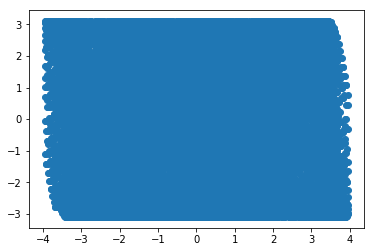

In [26]:
neuralmodel.eval() # put the model in eval mode
y_pred = neuralmodel(torch.FloatTensor(datas_train['X1']), torch.FloatTensor(datas_train['X2']))
before_train = criterion(y_pred, torch.FloatTensor(datas_train['y']))
print('Test loss before training' , before_train.item())

y_pred_train = neuralmodel(torch.FloatTensor(datas_train['X1']), torch.FloatTensor(datas_train['X2']))
y_pred_valid = neuralmodel(torch.FloatTensor(datas_valid['X1']), torch.FloatTensor(datas_valid['X2']))

plt.scatter(datas_train['y'],y_pred_train.detach().numpy())#,xlabel="Measurements", ylabel="Predictions")

# Training!

In [27]:
time1 = time.time()
neuralmodel.train()
epoch = 200
record_loss_train = np.zeros(epoch)
record_loss_valid = np.zeros(epoch)

for epoch in range(epoch):

    #
    # TRAINING
    #
    running_loss = 0     #accumulates loss of each batch
    its = 0 # monitor the number of minibatch
    for x1_, x2_, y_ in loader_train:
        
        # if we were not sending the data to device before, we can do it there
        #x1_batch, x2_batch, y_batch = x1_.to(device), x2_.to(device),y_.to(device) # Transfer to GPU
    
        yhat=neuralmodel(x1_, x2_) # calculating predicted y
        loss=criterion(yhat,y_) # loss criterion
        running_loss += loss.item()   # accumulating loss
        its += 1
        
        optimizer.zero_grad() # initialise gradient
        loss.backward() # backward gradient determination
        optimizer.step() # optimiser call and step
           
    record_loss_train[epoch] = running_loss/its # average loss other the minibatch
    
    if epoch % 20 == 0:
        print('Epoch {}: train loss: {}'.format(epoch, running_loss/its))
    
    #
    # MONITORING VALIDATION SUBSET
    #
    # Validation
    with torch.set_grad_enabled(False):
        running_loss = 0     #accumulates loss of each batch
        its = 0 # monitor the number of minibatch
        for x1_, x2_, y_ in loader_valid:
            #x1_batch, x2_batch, y_batch = x1_.to(device), x2_.to(device),y_.to(device) # Transfer to GPU
            
            yhat=neuralmodel(x1_, x2_) # calculating predicted y
            loss=criterion(yhat,y_) # loss criterion
            running_loss += loss.item()   # accumulating loss
            its += 1
            
        record_loss_valid[epoch] = running_loss/its
        
time2 = time.time()

print("Running time in seconds:", time2-time1)

Epoch 0: train loss: 3.8524155171520738
Epoch 20: train loss: 0.45559737948049983
Epoch 40: train loss: 0.3874332001769399
Epoch 60: train loss: 0.3675263940569866
Epoch 80: train loss: 0.3491567437907299
Epoch 100: train loss: 0.34530811388808563
Epoch 120: train loss: 0.34230138774377755
Epoch 140: train loss: 0.34685921022690924
Epoch 160: train loss: 0.3349273969610053
Epoch 180: train loss: 0.3444442214017891
Running time in seconds: 227.35385751724243


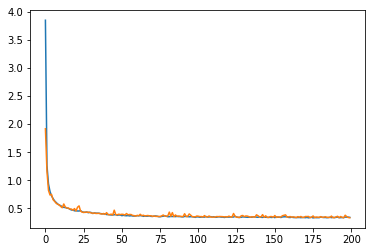

In [28]:
plt.plot(record_loss_train,label="Train")
plt.plot(record_loss_valid,label="Valid")

Text(0, 0.5, 'Predictions')

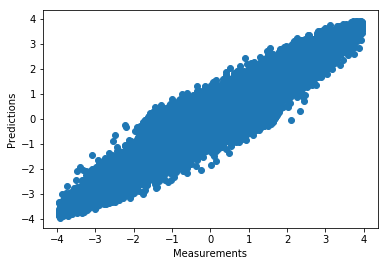

In [29]:
y_pred_train = neuralmodel(torch.FloatTensor(datas_train['X1']), torch.FloatTensor(datas_train['X2']))
y_pred_valid = neuralmodel(torch.FloatTensor(datas_valid['X1']), torch.FloatTensor(datas_valid['X2']))

plt.scatter(datas_train['y'],y_pred_train.detach().numpy())
plt.xlabel("Measurements") 
plt.ylabel("Predictions")